In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import random
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

from tqdm import tqdm
        
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, Dataset
import torchvision
from torchvision import datasets, transforms

import cv2

In [3]:
SEED = 42 # "Answer to the Ultimate Question of Life, the Universe, and Everything"
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

batch_s = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
valid_dir = '../input/chest-xray-pneumonia/chest_xray/val'
test_dir  = '../input/chest-xray-pneumonia/chest_xray/test'

img_size = 224

cuda


In [4]:
# unused (actually used for plotting), better way found (marked as "* better way")
def  generate_dataframes(root_dir):
    train_df = pd.DataFrame(columns=['xray_dir', 'pneumonia (label)'])
    test_df  = pd.DataFrame(columns=['xray_dir', 'pneumonia (label)'])
    valid_df = pd.DataFrame(columns=['xray_dir', 'pneumonia (label)'])
    
    for dirname, _, filenames in os.walk(root_dir):     
        
        # Train
        if dirname == root_dir + 'train/' + 'NORMAL':
            for filename in filenames:
                train_df.loc[len(train_df)] = [dirname + '/' + filename, 0]

        elif dirname == root_dir + 'train/' + 'PNEUMONIA':
            for filename in filenames:
                train_df.loc[len(train_df)] = [dirname + '/' + filename, 1]
        
        # Test
        if dirname == root_dir + 'test/' + 'NORMAL':
            for filename in filenames:
                test_df.loc[len(test_df)] = [dirname + '/' + filename, 0]

        elif dirname == root_dir + 'test/' + 'PNEUMONIA':
            for filename in filenames:
                test_df.loc[len(test_df)] = [dirname + '/' + filename, 1]
        
        # Validation
        if dirname == root_dir + 'val/' + 'NORMAL':
            for filename in filenames:
                valid_df.loc[len(valid_df)] = [dirname + '/' + filename, 0]

        elif dirname == root_dir + 'val/' + 'PNEUMONIA':
            for filename in filenames:
                valid_df.loc[len(valid_df)] = [dirname + '/' + filename, 1]
                
    return train_df, test_df, valid_df

In [5]:
train_df, test_df, valid_df = generate_dataframes('../input/chest-xray-pneumonia/chest_xray/')

In [6]:
train_df.head()

,xray_dir,pneumonia (label)
0,../input/chest-xray-pneumonia/chest_xray/train...,1
1,../input/chest-xray-pneumonia/chest_xray/train...,1
2,../input/chest-xray-pneumonia/chest_xray/train...,1
3,../input/chest-xray-pneumonia/chest_xray/train...,1
4,../input/chest-xray-pneumonia/chest_xray/train...,1


In [7]:
counts = train_df['pneumonia (label)'].value_counts()
counts

1    3875
0    1341
Name: pneumonia (label), dtype: int64

Text(0.5, 1.0, 'Pneumonia x Normal')

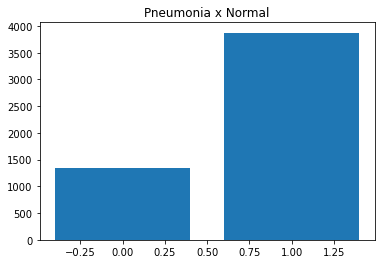

In [8]:
plt.bar(counts.index, counts) 
plt.title('Pneumonia x Normal')

In [9]:
class Dataset(Dataset):
    def __init__(self, data, target, transform=None, device=device):
        self.device = device
        self.data = data
        self.target = target
        self.transform = transform
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index].to(self.device)
        y = self.target[index].to(self.device)
        
        #if (y == 0) and self.transform: # check for minority class
        x = self.transform(x)
        
        return x, y

In [10]:
# Fixing unblaanced dataset with a weighted sampler
# based on code given by https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/2

# num_classes = 2
def unbalanced_dataset_weights(instances):
    count = [0] * 2
    for item in instances:
        count[item[1]] += 1
        
    class_weight = [0.] * 2
    total = float(sum(count))
    
    for i in range(2):
        class_weight[i] = total/float(count[i])
    
    weight = [0] * len(instances)
    
    for index, value in enumerate(instances):
        weight[index] = class_weight[value[1]]
        
    return weight

In [11]:
# * better way
transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor()])

train_ds = datasets.ImageFolder(train_dir, transform)
weights = unbalanced_dataset_weights(train_ds.imgs)
weights = torch.tensor(weights, dtype=torch.double)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_s, sampler= sampler)

valid_ds = datasets.ImageFolder(valid_dir, transform)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=False)

test_ds = datasets.ImageFolder(test_dir, transform)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [12]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, out_channels*depth, kernel_size=kernel_size, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(out_channels*depth, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        #print(out.size())
        return out

class conv_v1(nn.Module):
    def __init__(self):
        super(conv_v1, self).__init__()
        
        #self.input_size = 100
        
        """convs = [
            SeparableConv2d(in_channels=1, out_channels=32, depth=3, kernel_size=(32,32)),
            SeparableConv2d(in_channels=32, out_channels=64, depth=3, kernel_size=(32,32)),
            SeparableConv2d(in_channels=64, out_channels=64, depth=3, kernel_size=(32,32)),
            nn.GELU(),
            nn.GroupNorm(8, 64),
            SeparableConv2d(in_channels=64, out_channels=64, depth=3, kernel_size=(16,16)),
            SeparableConv2d(in_channels=64, out_channels=64, depth=3, kernel_size=(16,16)),
            SeparableConv2d(in_channels=64, out_channels=128, depth=3, kernel_size=(16,16)),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.GroupNorm(16, 128),
            SeparableConv2d(in_channels=128, out_channels=128, depth=3, kernel_size=(8,8)),
            SeparableConv2d(in_channels=128, out_channels=128, depth=3, kernel_size=(8,8)),
            SeparableConv2d(in_channels=128, out_channels=256, depth=3, kernel_size=(8,8)),
            nn.GELU(),
            nn.GroupNorm(32, 256),
            SeparableConv2d(in_channels=256, out_channels=256, depth=3, kernel_size=(8,8)),
            SeparableConv2d(in_channels=256, out_channels=512, depth=3, kernel_size=(8,8)),
            nn.GELU(),
            nn.GroupNorm(32, 512),
            SeparableConv2d(in_channels=512, out_channels=512, depth=3, kernel_size=(4,4)),
            SeparableConv2d(in_channels=512, out_channels=1024, depth=3, kernel_size=(4,4)),
            nn.GELU(),
            nn.GroupNorm(32, 1024),
            SeparableConv2d(in_channels=1024, out_channels=1024, depth=1, kernel_size=(2,2)),
            nn.GELU(),
            nn.GroupNorm(32, 1024)
        ]
        
        self.conv = nn.Sequential(*convs)"""
        
        """convs = [
            nn.Conv2d(1 , 32, kernel_size=32, stride=1),
            nn.Conv2d(32, 64, kernel_size=16, stride=1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=8, stride=2, dilation=1),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, dilation=2),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, dilation=1),
            nn.Conv2d(512, 1024, kernel_size=4, stride=1, dilation=2),
            nn.MaxPool2d(2),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2),
            nn.Conv2d(2048, 4096, kernel_size=1, stride=1)
        ]
        
        self.conv = nn.Sequential(*convs)"""
        
        self.resnext = torchvision.models.resnext50_32x4d()
        self.wide_resnet = torchvision.models.wide_resnet50_2()
        
        self.linear1 = nn.Linear(1000, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(256, 1)
            
        self.gelu = nn.GELU()
        #self.gelu_threshold = 0.7
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        """feature_maps = self.conv(x)"""
        feature_maps1 = self.resnext(x)
        feature_maps2 = self.wide_resnet(x)
        
        #print(torch.flatten(feature_maps, start_dim=1).size())
        #print(torch.flatten(feature_maps2, start_dim=1).size())
        
        hidden1 = self.gelu(self.linear1(torch.flatten(feature_maps1, start_dim=1)))
        hidden1 = self.gelu(self.linear2(hidden1))
        
        hidden2 = self.gelu(self.linear1(torch.flatten(feature_maps2, start_dim=1)))
        hidden2 = self.gelu(self.linear2(hidden2))
        
        hidden = torch.cat((hidden1, hidden2), 1)
        
        #out = hidden
        out = self.sigmoid(self.linear3(hidden))
        out = torch.squeeze(out)
        out = out.type(torch.float)
        return out

In [13]:
model = conv_v1()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4, weight_decay = 10e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.BCELoss()
print(model)

conv_v1(
  (resnext): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [14]:
print(device)

cuda


In [15]:
epochs = 3
valid_size = len(valid_dataloader)
lowest = -1 #best  running_loss
losses = []

for epoch in range(epochs):
    print(f"Training epoch {epoch}\n")
    
    train_running_loss = 0.0 # for loss moving average
    valid_running_loss = 0.0
    
    # precision / rcall analysis
    total_p = 0 
    total_n = 0
    
    correct_preds_count = 0
    total_count         = 0
    
    tp = 0 # true positive
    fp = 0 # false positive
    tn = 0 # true negative
    fn = 0 # false negative
    
    for dataset_size_multiplier in range(5):
        for index, data in tqdm(enumerate(train_dataloader)):
            model.train()

            batch_inputs, batch_labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.float)

            outputs = model(batch_inputs)
            loss    = criterion(outputs, batch_labels)

            #print(f"TRAIN: Step {index} loss: {loss}")

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
            if (index + 1) % 10 == 0:
                if (lowest == -1):
                    lowest = train_running_loss / 10
                    torch.save(model.state_dict(), "./best.pth")
                elif (lowest > train_running_loss / 10):
                    lowest = train_running_loss / 10
                    torch.save(model.state_dict(), "./best.pth")
                print(f'Epoch: {epoch+1}, step: {index+1}, training loss moving average: {train_running_loss / 10}')

                losses.append(loss.item())
                train_running_loss = 0.0



            for i in range(len(batch_labels)):
                # out: 1 and lab: 1 (tp)
                if outputs[i] >= 0.5 and batch_labels[i] == 1:
                    tp += 1
                    total_p += 1

                    total_count += 1
                    correct_preds_count += 1

                elif (outputs[i] >= 0.5 and batch_labels[i] == 0):
                    fp += 1
                    total_n += 1

                    total_count += 1

                elif (outputs[i] < 0.5 and batch_labels[i] == 0):
                    tn += 1
                    total_n += 1

                    total_count += 1
                    correct_preds_count += 1

                else:
                    fn += 1
                    total_p += 1

                    total_count += 1

    print(f'Epoch {epoch+1}:\n    Accuracy: {correct_preds_count} out of {total_count} ({correct_preds_count/total_count}%)\n    Precision: {tp / (tp + fp)}\n    Recall: {tp / (tp + tn)}\n    Conf. Mat:\n    [{tp}, {fp}]\n    [{fn}, {tn}]')
    
    for index, data in enumerate(valid_dataloader):
        model.eval()
        
        batch_inputs, batch_labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.float)
        
        outputs = model(batch_inputs)
        loss    = criterion(outputs, batch_labels)
        valid_running_loss += loss.item()
        if index+1 == valid_size:
            print(f'Epoch: {epoch+1}, mini_batch: {index+1}, validation mean loss: {valid_running_loss / valid_size}\n\n\n')
            valid_running_loss = 0.0

0it [00:00, ?it/s]

Training epoch 0



10it [00:10,  1.28s/it]

Epoch: 1, step: 10, training loss moving average: 0.731202045083046


20it [00:19,  1.07it/s]

Epoch: 1, step: 20, training loss moving average: 0.7740419149398804


30it [00:29,  1.20s/it]

Epoch: 1, step: 30, training loss moving average: 0.6202128767967224


40it [00:39,  1.22s/it]

Epoch: 1, step: 40, training loss moving average: 0.46268714070320127


50it [00:49,  1.22s/it]

Epoch: 1, step: 50, training loss moving average: 0.3900141090154648


60it [00:57,  1.14it/s]

Epoch: 1, step: 60, training loss moving average: 0.4336898148059845


70it [01:06,  1.18it/s]

Epoch: 1, step: 70, training loss moving average: 0.39530224800109864


80it [01:14,  1.15it/s]

Epoch: 1, step: 80, training loss moving average: 0.4109488666057587


90it [01:24,  1.15s/it]

Epoch: 1, step: 90, training loss moving average: 0.3567578554153442


100it [01:32,  1.20it/s]

Epoch: 1, step: 100, training loss moving average: 0.3848047606647015


110it [01:40,  1.20it/s]

Epoch: 1, step: 110, training loss moving average: 0.39864993542432786


120it [01:50,  1.20s/it]

Epoch: 1, step: 120, training loss moving average: 0.3215501055121422


130it [01:58,  1.30it/s]

Epoch: 1, step: 130, training loss moving average: 0.34560040235519407


140it [02:06,  1.27it/s]

Epoch: 1, step: 140, training loss moving average: 0.32926770150661466


150it [02:14,  1.19it/s]

Epoch: 1, step: 150, training loss moving average: 0.37649370431900026


160it [02:22,  1.25it/s]

Epoch: 1, step: 160, training loss moving average: 0.3300091281533241


170it [02:32,  1.17s/it]

Epoch: 1, step: 170, training loss moving average: 0.27287609577178956


180it [02:40,  1.20it/s]

Epoch: 1, step: 180, training loss moving average: 0.28073572739958763


190it [02:48,  1.26it/s]

Epoch: 1, step: 190, training loss moving average: 0.3090549036860466


200it [02:56,  1.28it/s]

Epoch: 1, step: 200, training loss moving average: 0.3723643958568573


210it [03:04,  1.24it/s]

Epoch: 1, step: 210, training loss moving average: 0.39813715368509295


220it [03:13,  1.21s/it]

Epoch: 1, step: 220, training loss moving average: 0.2670276269316673


230it [03:21,  1.09it/s]

Epoch: 1, step: 230, training loss moving average: 0.3356120616197586


240it [03:29,  1.26it/s]

Epoch: 1, step: 240, training loss moving average: 0.31400199234485626


250it [03:37,  1.35it/s]

Epoch: 1, step: 250, training loss moving average: 0.37989782094955443


260it [03:46,  1.08s/it]

Epoch: 1, step: 260, training loss moving average: 0.26506929844617844


270it [03:54,  1.15it/s]

Epoch: 1, step: 270, training loss moving average: 0.2859658978879452


280it [04:02,  1.36it/s]

Epoch: 1, step: 280, training loss moving average: 0.31416675373911856


290it [04:09,  1.30it/s]

Epoch: 1, step: 290, training loss moving average: 0.30083210617303846


300it [04:17,  1.36it/s]

Epoch: 1, step: 300, training loss moving average: 0.2744904860854149


310it [04:25,  1.21it/s]

Epoch: 1, step: 310, training loss moving average: 0.29552665650844573


320it [04:33,  1.31it/s]

Epoch: 1, step: 320, training loss moving average: 0.392935574054718


326it [04:37,  1.17it/s]
10it [00:07,  1.27it/s]

Epoch: 1, step: 10, training loss moving average: 0.48583801090717316


20it [00:15,  1.30it/s]

Epoch: 1, step: 20, training loss moving average: 0.30347866043448446


30it [00:23,  1.23it/s]

Epoch: 1, step: 30, training loss moving average: 0.2823100119829178


40it [00:31,  1.29it/s]

Epoch: 1, step: 40, training loss moving average: 0.5312081545591354


50it [00:39,  1.31it/s]

Epoch: 1, step: 50, training loss moving average: 0.3761445999145508


53it [00:42,  1.26it/s]


KeyboardInterrupt: 

In [16]:
model.load_state_dict(torch.load('./best.pth'))

running_loss = 0.0
test_losses = []
test_loss_average = 0

for index, data in tqdm(enumerate(test_dataloader)):
    model.eval()
    batch_inputs, batch_labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.float)
        
    outputs = model(batch_inputs)
    assert isinstance(outputs.item(), float)
    loss    = criterion(outputs, batch_labels)
    
    #print(f"Step {index} loss: {loss}")
    running_loss += loss.item()
    
test_loss_average = running_loss / len(test_dataloader)
print(test_loss_average)


0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
624it [00:39, 15.84it/s]

0.6498524064604098


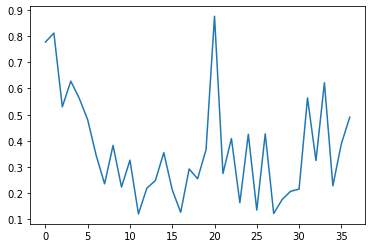

In [17]:
plt.plot(losses)
plt.show()

In [ ]:
!pip install py7zr

In [19]:
!py7zr c target.7z '/kaggle/working/best.pth'

In [20]:
!du -h '/kaggle/working/target.7z'

331M	/kaggle/working/target.7z


In [21]:
!du -h '/kaggle/working/best.pth'

362M	/kaggle/working/best.pth
